# Utils

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from geodesic_toolbox import *
from utils import *

<Axes: >

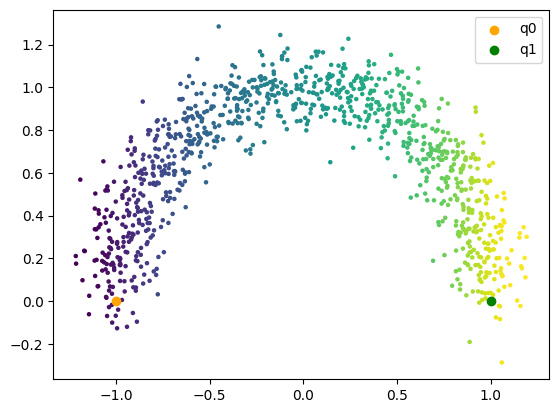

In [2]:
X, t = generate_half_moon_data(n_samples=1000, noise=0.1)
X = X.to(torch.float32)
idx = torch.randint(0, X.shape[0], (2,))

# X = X[X[:, 0] < -0.2 or X[:, 0] > 0.2]
# idx = torch.logical_or(X[:, 0] < -0.4, X[:, 0] > 0.4)
# idx_ = torch.logical_and(X[:, 0] > -0.2, X[:, 0] < 0.2)
# idx = torch.logical_or(idx, idx_)
# X = X[idx]
# t = t[idx]
# q0 = X[idx[0]].unsqueeze(0)
# q1 = X[idx[1]].unsqueeze(0)
q0 = torch.Tensor([[-1.0, 0.0]])
q1 = torch.Tensor([[1.0, 0.0]])

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c=t)
plot_traj(q0=q0, q1=q1, ax=ax)

# Build cometric

In [3]:
base_cometric = IdentityCoMetric()
cometric = CentroidsCometric(
    centroids=X,
    # cometric_centroids=base_cometric(X),
    cometric_centroids=torch.diag_embed(base_cometric(X)),
    temperature=0.1,
    # K=256,
)

In [4]:
cometric.is_diag

False

Computing magnification factor: 100%|██████████| 79/79 [00:00<00:00, 180.88batch/s]


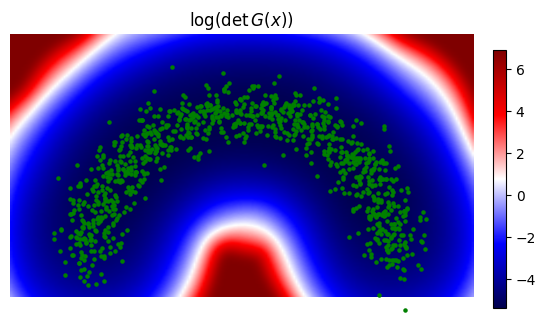

In [5]:
extent = (-1.5, 1.5, -0.2, 1.5)
mf = get_mf_image(cometric, X, bounds=extent)
plt.figure()
img = plt.imshow(
    mf.log(),
    extent=extent,
    origin="lower",
    cmap="seismic",
    interpolation="bilinear",
)
plt.scatter(X[:, 0], X[:, 1], s=5, c="green")
plt.colorbar(img, fraction=0.026, pad=0.04)
plt.title(r"""$\log(\det G(x))$""")
plt.axis("off")
plt.show()

<Axes: >

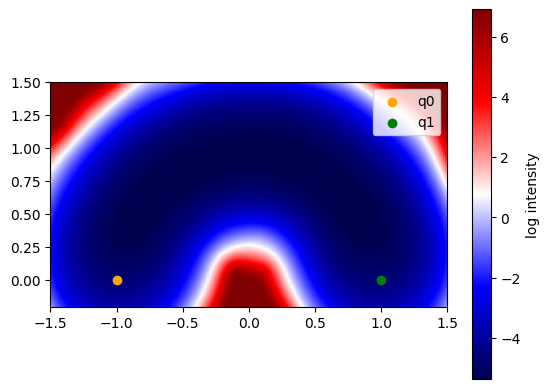

In [6]:
plot_traj(q0=q0, q1=q1, img=mf, extent=extent)

# Geodesic equations

In [7]:
def sample_pts(cometric, q0, N_pts, std=0.2):
    """
    Sample tangent vectors from the normal distribution N(0, G_inv(q0))

    Parameters
    ----------
    cometric : CoMetric
    q0 : torch.Tensor (d,)
        Point at which to sample
    N_pts : int
        Number of points to sample
    std : float
        Standard deviation of the normal distribution

    Returns
    -------
    v : torch.Tensor (N_pts, d)
        Sampled points
    """
    G_inv = cometric.cometric_tensor(q0.unsqueeze(0)).squeeze(0)
    if cometric.is_diag:
        L = G_inv.sqrt()
    else:
        L = torch.linalg.cholesky(G_inv)
    # Sample according to N(0, G_inv)
    v = torch.randn((N_pts, 2)) * std
    if cometric.is_diag:
        v = v * L
    else:
        v = torch.einsum("ij,bj->bi", L, v)

    return v

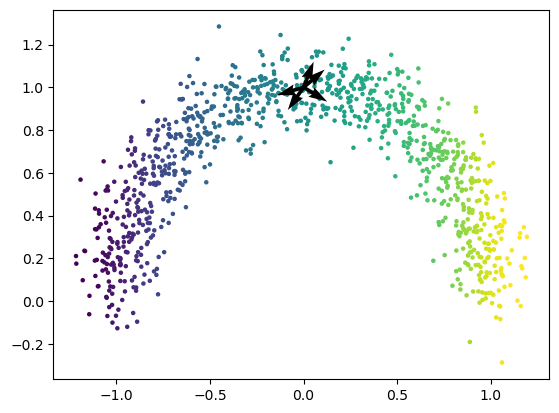

In [8]:
N_pts = 5
q0 = torch.tensor([0, 1.0]).requires_grad_(True)
v0 = sample_pts(cometric, q0, N_pts, std=0.1)
q0 = q0.unsqueeze(0).repeat(v0.shape[0], 1)
plt.scatter(X[:, 0], X[:, 1], s=5, c=t)
for b in range(q0.shape[0]):
    plt.quiver(
        q0[b, 0].detach(),
        q0[b, 1].detach(),
        v0[b, 0].detach(),
        v0[b, 1].detach(),
    )

In [9]:
expmap = ExpMapRiemann(cometric, T_max=0.2, T=100, method="dopri5")

traj = expmap(q0, v0, convert_to_moment=False).detach()

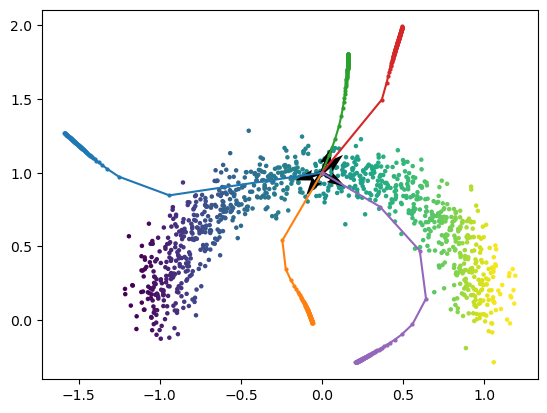

In [10]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=t)
for b in range(traj.shape[0]):
    plt.plot(traj[b, :, 0], traj[b, :, 1], marker="o", markersize=2)
    plt.quiver(
        q0[b, 0].detach(),
        q0[b, 1].detach(),
        v0[b, 0].detach(),
        v0[b, 1].detach(),
        # scale=5,
    )

# Riemannian manifold

In [7]:
georce_solver = GEORCE(cometric=cometric, pbar=True)
shooting_solver = ShootingSolver(cometric=cometric, verbose=True)
graph_solver = SolverGraph(cometric=cometric, data=X, n_neighbors=8)
# bvp_solver = BVP_ode(cometric=cometric, verbose=1)
dual_solver = SolverGraphGEORCE(
    cometric=cometric, data=X, n_neighbors=8, tol=1e-6, pbar_georce=True
)

Fitting KNN graph...


Initialize Graph:   0%|          | 0/16 [00:00<?, ?batch/s]

Initialize Graph: 100%|██████████| 16/16 [00:07<00:00,  2.25batch/s]


Computing predecessors...
Done.
Fitting KNN graph...


Initialize Graph: 100%|██████████| 16/16 [00:06<00:00,  2.42batch/s]

Computing predecessors...
Done.


In [8]:
traj_graph = graph_solver.get_trajectories(q0, q1)
traj_shooting = shooting_solver.get_trajectories(q0, q1)
# # traj_bvp = bvp_solver.get_trajectories(q0.to(torch.double), q1.to(torch.double))
traj_georce = georce_solver.get_trajectories(q0, q1)
traj_dual = dual_solver.get_trajectories(q0, q1)

/home/tblanchard/phd/geodesic_toolbox/src/geodesic_toolbox/utils.py:216: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  new_lr = (1 - exp(-coef * mf)) * max_scale * base_lr + min_scale * base_lr


Optimisation did not converge after 100 steps. MMSE shooting loss : 1.1608508825302124
 last_loss = [1.1608509]


i=004 | alpha: 2.500E-01, E = 4.868E-04, grad_E = 9.291E-07,  dst = 2.081E-01:   2%|▏         | 4/200 [00:00<00:02, 68.39it/s]
i=005 | alpha: 2.500E-01, E = 4.868E-04, grad_E = 9.291E-07,  dst = 2.081E-01:   5%|▌         | 5/100 [00:00<00:03, 29.56it/s]

In [9]:
dst_graph = graph_solver.compute_distance(traj_graph)
dst_georce = graph_solver.compute_distance(traj_georce)
dst_shooting = graph_solver.compute_distance(traj_shooting)
# dst_bvp = graph_solver.compute_distance(traj_bvp)
dst_dual = graph_solver.compute_distance(traj_dual)

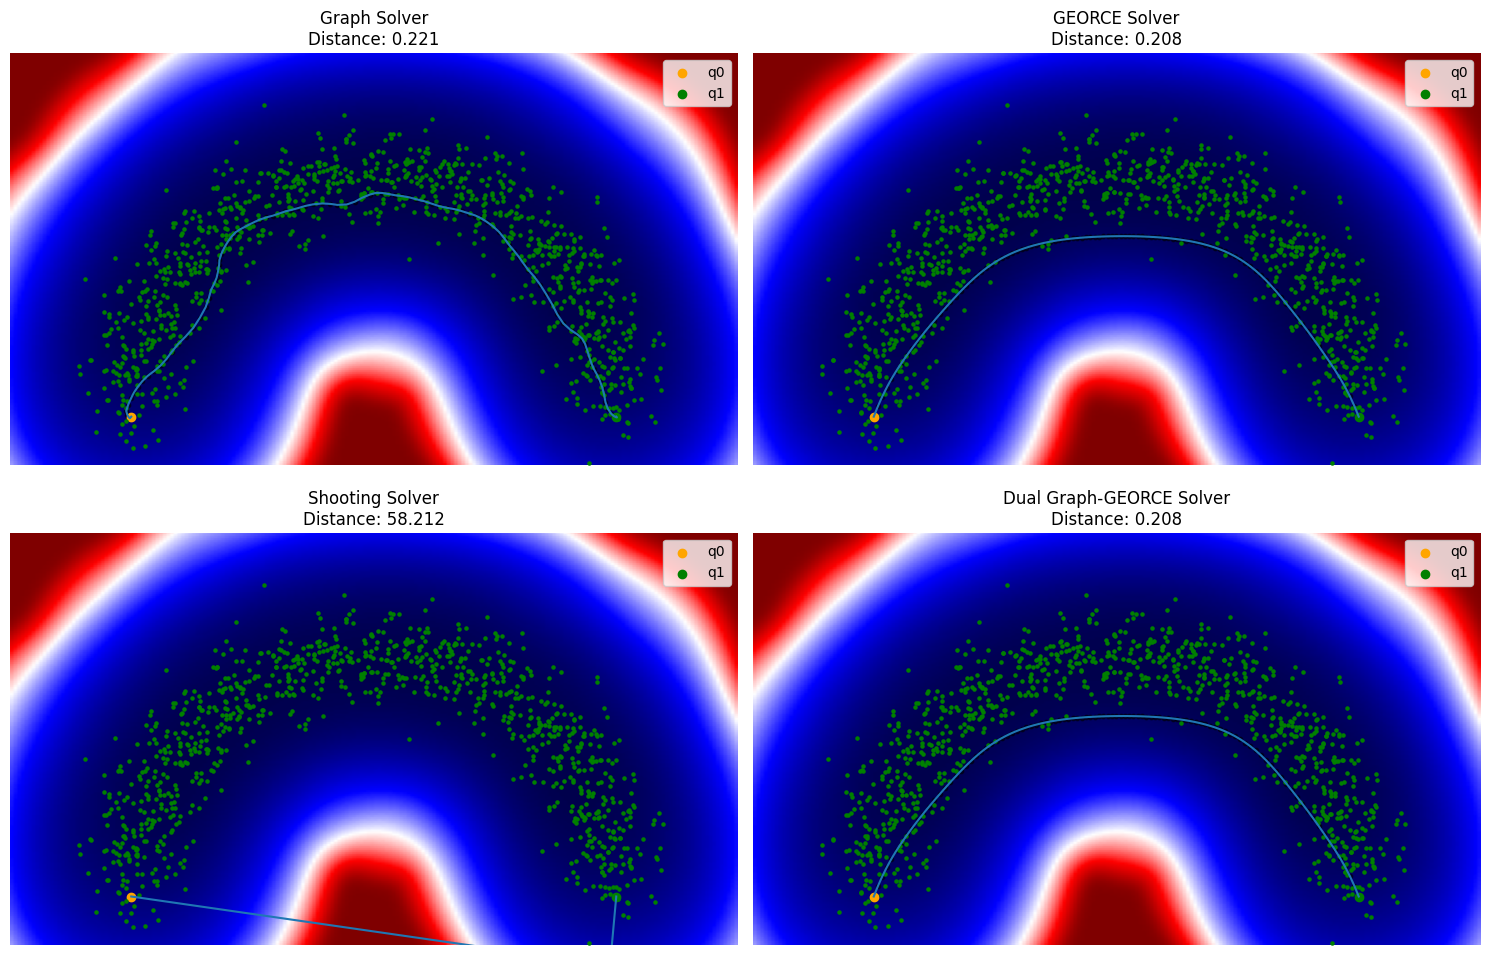

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
plot_traj(x_t=traj_graph, q0=q0, q1=q1, img=mf, extent=extent, ax=axes[0], cbar=False)
axes[0].set_title(f"Graph Solver\nDistance: {dst_graph.mean().item():.3f}")
plot_traj(x_t=traj_georce, q0=q0, q1=q1, img=mf, extent=extent, ax=axes[1], cbar=False)
axes[1].set_title(f"GEORCE Solver\nDistance: {dst_georce.mean().item():.3f}")
plot_traj(x_t=traj_shooting, q0=q0, q1=q1, img=mf, extent=extent, ax=axes[2], cbar=False)
axes[2].set_title(f"Shooting Solver\nDistance: {dst_shooting.mean().item():.3f}")
plot_traj(x_t=traj_dual, q0=q0, q1=q1, img=mf, extent=extent, ax=axes[3], cbar=False)
axes[3].set_title(f"Dual Graph-GEORCE Solver\nDistance: {dst_dual.mean().item():.3f}")
for ax in axes:
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    ax.axis("off")
    ax.scatter(X[:, 0], X[:, 1], s=5, c="green")
plt.tight_layout()
plt.show()